In [2]:
# Nhập các thư viện cần thiết
import os
import librosa
import librosa.display
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input


In [3]:
# Định nghĩa thư mục chứa dữ liệu
dataset_path = "./data/"
emotions = os.listdir(dataset_path)  # Lấy danh sách các thư mục cảm xúc
EMOTIONS = ["Angry", "Disgusted", "Fearful", "Happy", "Neutral", "Sad", "Surprised"]

# Hàm trích xuất đặc trưng MFCC từ file âm thanh
def extract_features(file_path):
    try:
        audio, sr = librosa.load(file_path, sr=None)  # Đọc file âm thanh
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)  # Tính toán MFCC
        return np.mean(mfcc, axis=1)  # Lấy giá trị trung bình trên mỗi hệ số MFCC
    except Exception as e:
        print(f"Lỗi khi đọc file {file_path}: {e}")
        return None

# Khởi tạo danh sách lưu dữ liệu đặc trưng và nhãn cảm xúc
X, y = [], []
for label, emotion in enumerate(emotions):
    emotion_path = os.path.join(dataset_path, emotion)
    for file in os.listdir(emotion_path):
        file_path = os.path.join(emotion_path, file)
        features = extract_features(file_path)
        if features is not None:
            X.append(features)
            y.append(label)

X, y = np.array(X), np.array(y)  # Chuyển danh sách thành mảng numpy


In [5]:
# Chuẩn hóa dữ liệu để đưa về cùng một thang đo
scaler = StandardScaler()
X = scaler.fit_transform(X)
joblib.dump(scaler, "scaler.pkl")  # Lưu bộ chuẩn hóa để sử dụng sau

# Chia tập dữ liệu thành tập huấn luyện (80%) và tập kiểm tra (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
# Khởi tạo và huấn luyện mô hình K-Nearest Neighbors (KNN)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
joblib.dump(knn, "knn_model.pkl")  # Lưu mô hình
print(f"Độ chính xác KNN: {knn.score(X_test, y_test):.2f}")


Độ chính xác KNN: 0.55


In [7]:
# Khởi tạo và huấn luyện mô hình Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
joblib.dump(dt, "decision_tree_model.pkl")  # Lưu mô hình
print(f"Độ chính xác Decision Tree: {dt.score(X_test, y_test):.2f}")


Độ chính xác Decision Tree: 0.44


In [8]:
# Xây dựng mô hình mạng Neural Network
nn = Sequential([
    Input(shape=(13,)),  # Đầu vào có 13 đặc trưng MFCC
    Dense(16, activation='relu'),  # Lớp ẩn thứ nhất
    Dense(8, activation='relu'),  # Lớp ẩn thứ hai
    Dense(len(emotions), activation='softmax')  # Lớp đầu ra với số lượng lớp bằng số cảm xúc
])

# Biên dịch mô hình
nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Huấn luyện mô hình
history = nn.fit(X_train, y_train, epochs=30, batch_size=8, validation_data=(X_test, y_test), verbose=1)
nn.save("neural_network_model.keras")  # Lưu mô hình
print(f"Độ chính xác Neural Network: {nn.evaluate(X_test, y_test, verbose=0)[1]:.2f}")


Epoch 1/30
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2435 - loss: 1.8429 - val_accuracy: 0.3496 - val_loss: 1.5939
Epoch 2/30
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3819 - loss: 1.5292 - val_accuracy: 0.4121 - val_loss: 1.4554
Epoch 3/30
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4290 - loss: 1.4234 - val_accuracy: 0.4375 - val_loss: 1.4058
Epoch 4/30
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4388 - loss: 1.3926 - val_accuracy: 0.4422 - val_loss: 1.3731
Epoch 5/30
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4587 - loss: 1.3502 - val_accuracy: 0.4547 - val_loss: 1.3532
Epoch 6/30
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4616 - loss: 1.3403 - val_accuracy: 0.4590 - val_loss: 1.3345
Epoch 7/30
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4718 - loss: 1.3139 - val_accuracy: 0.4680 - val_loss: 1.3228
Epoch 8/30
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4796 - loss: 1.2842 - 

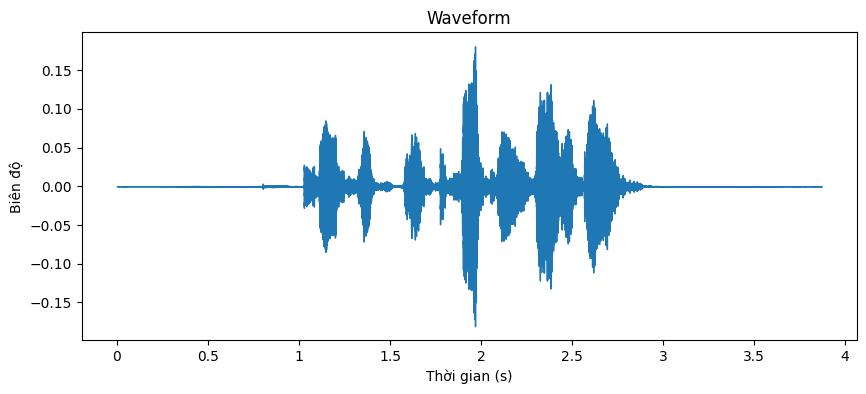

In [9]:
# Hiển thị dữ liệu dạng sóng của một file âm thanh
def plot_waveform(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio, sr=sr)
    plt.title("Waveform")
    plt.xlabel("Thời gian (s)")
    plt.ylabel("Biên độ")
    plt.show()

# Hiển thị waveform của một file mẫu
sample_file = os.path.join(dataset_path, emotions[0], os.listdir(os.path.join(dataset_path, emotions[0]))[0])
plot_waveform(sample_file)

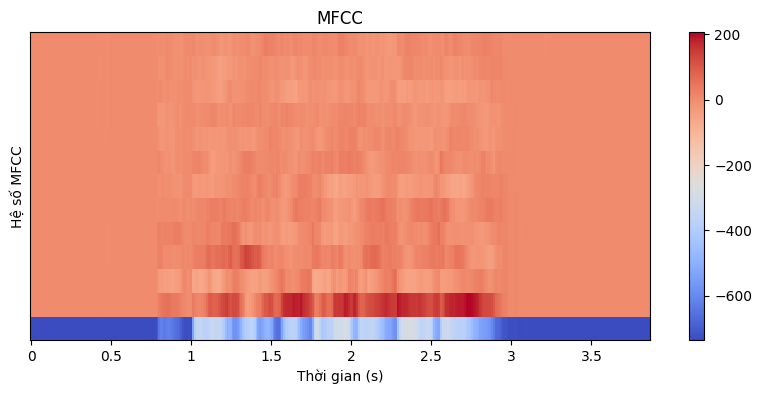

In [10]:
# Hiển thị MFCC của một file âm thanh
def plot_mfcc(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc, sr=sr, x_axis='time')
    plt.colorbar()
    plt.title("MFCC")
    plt.xlabel("Thời gian (s)")
    plt.ylabel("Hệ số MFCC")
    plt.show()

# Hiển thị MFCC của file mẫu
plot_mfcc(sample_file)

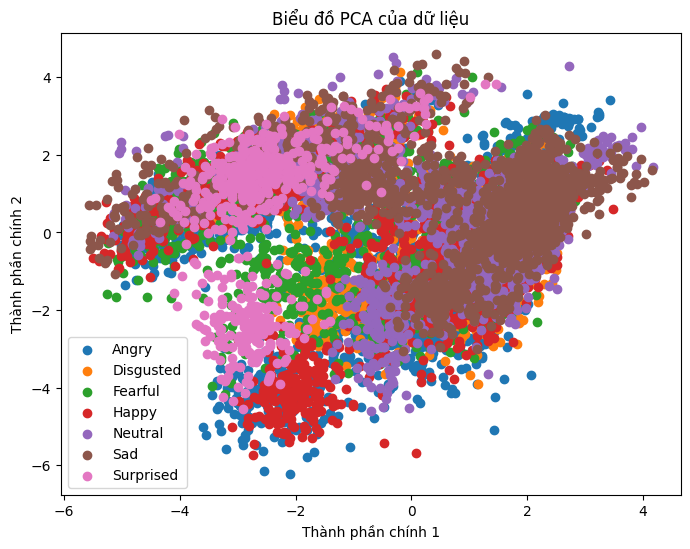

In [11]:
# Giảm chiều dữ liệu bằng PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Trực quan hóa dữ liệu sau PCA
plt.figure(figsize=(8, 6))
for i, label in enumerate(np.unique(y)):
    plt.scatter(X_pca[y == label, 0], X_pca[y == label, 1], label=EMOTIONS[label])
plt.legend()
plt.title("Biểu đồ PCA của dữ liệu")
plt.xlabel("Thành phần chính 1")
plt.ylabel("Thành phần chính 2")
plt.show()

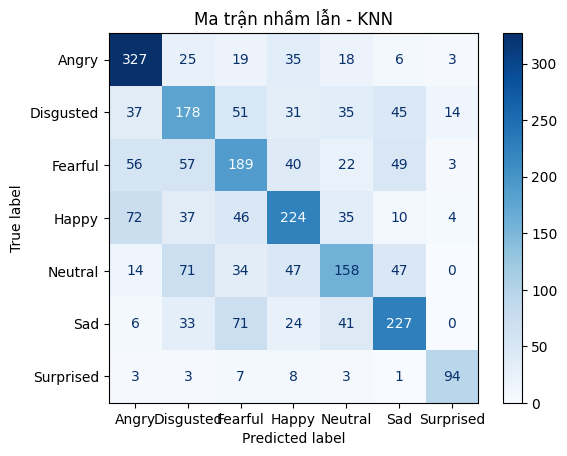

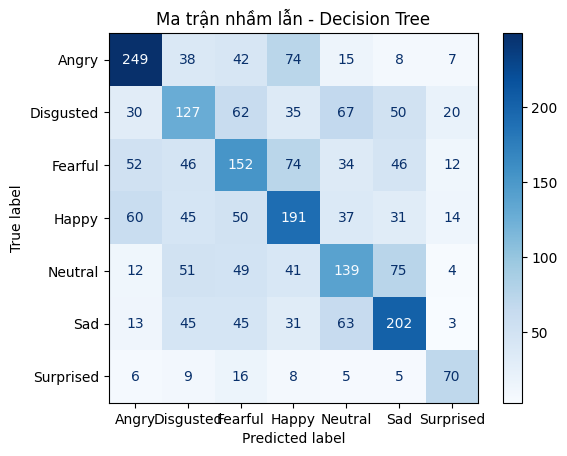

In [12]:
# Hàm vẽ ma trận nhầm lẫn
def plot_confusion_matrix(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=EMOTIONS)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Vẽ ma trận nhầm lẫn cho KNN, Decision Tree
plot_confusion_matrix(knn, X_test, y_test, "Ma trận nhầm lẫn - KNN")
plot_confusion_matrix(dt, X_test, y_test, "Ma trận nhầm lẫn - Decision Tree")

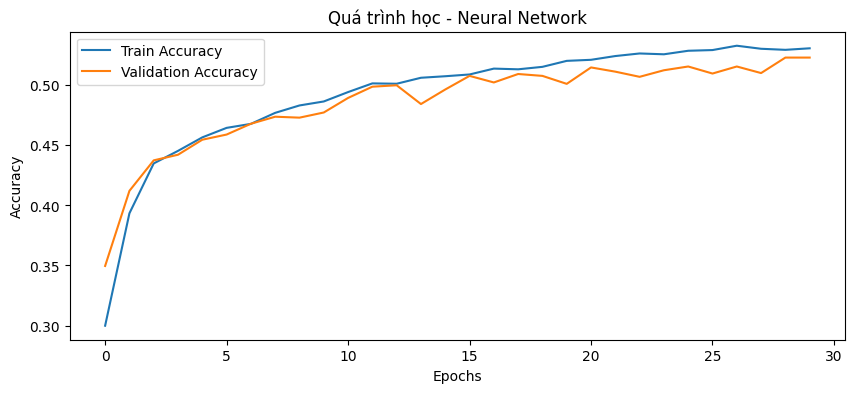

In [13]:
# Vẽ biểu đồ quá trình học của Neural Network
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Quá trình học - Neural Network")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

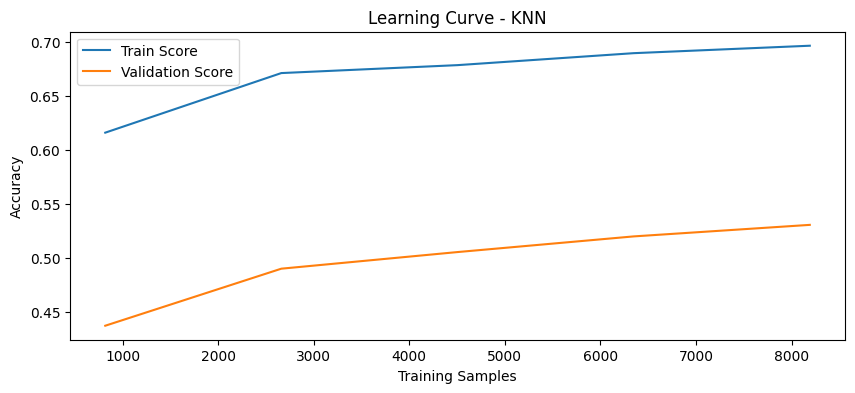

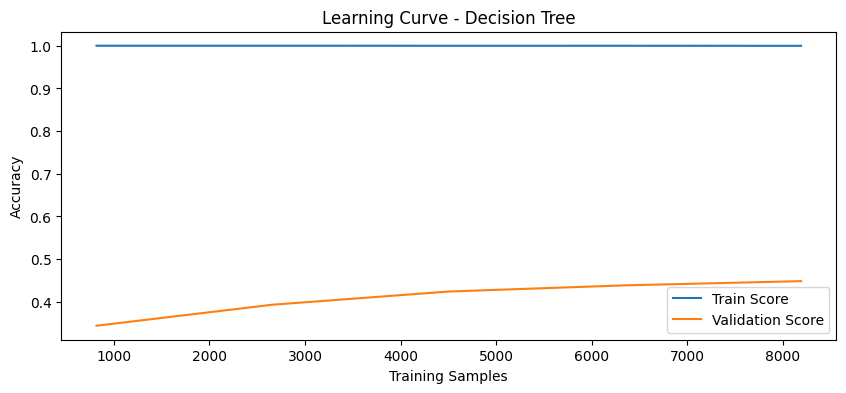

In [14]:
# Hàm vẽ learning curve
def plot_learning_curve(model, X_train, y_train, title):
    train_sizes, train_scores, val_scores = learning_curve(model, X_train, y_train, cv=5, scoring='accuracy')
    
    plt.figure(figsize=(10, 4))
    plt.plot(train_sizes, train_scores.mean(axis=1), label='Train Score')
    plt.plot(train_sizes, val_scores.mean(axis=1), label='Validation Score')
    plt.title(title)
    plt.xlabel("Training Samples")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

# Vẽ learning curve cho KNN và Decision Tree
plot_learning_curve(knn, X_train, y_train, "Learning Curve - KNN")
plot_learning_curve(dt, X_train, y_train, "Learning Curve - Decision Tree")